### Three-Layer NTK

#### [NTK paper](https://papers.nips.cc/paper/2019/file/c4ef9c39b300931b69a36fb3dbb8d60e-Paper.pdf)

#### [REU overleaf doc](https://www.overleaf.com/project/606a0e1c8d7e5e3b95b62e9a)

#### [GitHub Repo for this project](https://github.com/genglinliu/NTK-study)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
activation functions and their derivatives
"""

def relu_k(x, k):
    return np.maximum(x**k, 0)

def d_relu_k(x, k):
    return k * x**(k-1) * (x > 0)

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return 1.0 * (x > 0)

def sin(x, k=None):
    return np.sin(x)

def cos(x, k=None):
    return np.cos(x)

def d_cos(x, k=None):
    return -np.sin(x)

In [3]:
def init_inputs(num_inputs=100):
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniformly sampled
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * np.pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta))) # (2, 100)
    return x

In [4]:
# check kernel symmetry and positive definitiveness
def check(matrix, tol=1e-7):
    if not np.all(np.abs(matrix-matrix.T) < tol):
        print("warning: kernel is not symmetric")
    if not np.all(np.linalg.eigvals(matrix) >= -tol):
        print("warning: kernel is not positive semi-definite")

In [5]:
def plot_eigendecay(kernel, label):
    # plot
    eigenvalues = np.linalg.eigvals(kernel)
    # sort in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    plt.loglog(sorted_eigenvalues[:-1], label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_eigendecay_trig(kernel, label):
    # plot
    eigenvalues = np.linalg.eigvals(kernel)
    # sort in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    plt.yscale('log')
    plt.plot(sorted_eigenvalues[:-100], label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Enrty-wise Computation - following the formulas on the Paper

In [6]:
"""
see page 3-4 of the paper

STEP 0
    x and x' are 2-dimensional points of shape (2,)
    K_0(x, x') = sigma_0(x, x') = <x, x'> = (x^T).dot(x')

STEP 1a
    B_1 = [sigma_0(x, x),  sigma_0(x, x'),
           sigma_0(x, x'), sigma_0(x', x')]
           
STEP 1b
    sigma_1(x, x') = 2 E(u, v)~N(0, B_1) [activation(u) activation(v)]
    sigma_1'(x, x') = 2 E(u, v)~N(0, B_1) [activation'(u) activation'(v)]

STEP 1c
    K_1(x, x') = sigma_1(x, x') + K_0(x, x') sigma_1'(x, x')

"""
#------------
# step 0
#------------   
def K_0(x, y):
    return np.dot(x.T, y)

def sigma_0(x, y):
    return np.dot(x.T, y)

#------------
# step 1a
#------------
def B_1(x, y):
    v1 = np.vstack((sigma_0(x, x), sigma_0(x, y)))
    v2 = np.vstack((sigma_0(x, y), sigma_0(y, y)))

    return np.hstack((v1, v2))

#------------
# step 1b
#------------
def sigma_1_and_prime(x, y, activation, k):
    
    activation_map = {
        'relu_k': [relu_k, d_relu_k],
        'sin': [sin, cos],
        'cos': [cos, d_cos]
    }
        
#     mean = np.zeros(x.shape[0])
#     cov = B_1(x, y)
#     num_samples = 1000
#     # generate 1000 pairs of (u, v), apply activation array-wise then take average
#     sample_1 = np.random.multivariate_normal(mean, cov, num_samples) # (num_samples, 2)
#     u1, v1 = sample_1[:, 0], sample_1[:, 1] # (num_samples,)
    
#     sample_2 = np.random.multivariate_normal(mean, cov, num_samples) # (num_samples, 2)
#     u2, v2 = sample_2[:, 0], sample_2[:, 1] # (num_samples,)
    
    activation_func, d_activation = activation_map[activation]
    expectation_1 = np.mean(activation_func(u1, k) * activation_func(v1, k))
    expectation_2 = np.mean(d_activation(u2, k) * d_activation(v2, k))

    sigma_1 = 2 * expectation_1
    sigma_1_prime = 2 * expectation_2
    
    return sigma_1, sigma_1_prime

#------------
# step 1c
#------------
def K_1(x, y, activation, k=1):
    sigma_1, sigma_1_prime = sigma_1_and_prime(x, y, activation, k)
    return sigma_1 + K_0(x, y) * sigma_1_prime



In [7]:
"""
STEP 2a
    B_2 = [sigma_1(x, x),  sigma_1(x, x'),
           sigma_1(x, x'), sigma_1(x', x')]
           
STEP 2b
    sigma_2(x, x') = 2 E(u, v)~N(0, B_2) [activation(u) activation(v)]
    sigma_2'(x, x') = 2 E(u, v)~N(0, B_2) [activation'(u) activation'(v)]

STEP 2c
    K_2(x, x') = sigma_2(x, x') + K_1(x, x') sigma_2'(x, x')

"""

#------------
# step 2a
#------------
def B_2(x, y, activation_h1, k):
    sigma_1_xx, _ = sigma_1_and_prime(x, x, activation_h1, k)
    sigma_1_xy, _ = sigma_1_and_prime(x, y, activation_h1, k)
    sigma_1_yy, _ = sigma_1_and_prime(y, y, activation_h1, k)
    
    v1 = np.vstack((sigma_1_xx, sigma_1_xy))
    v2 = np.vstack((sigma_1_xy, sigma_1_yy))

    return np.hstack((v1, v2))


#------------
# step 2b
#------------
def sigma_2_and_prime(x, y, activation_h2, k):
    
    activation_map = {
        'relu_k': [relu_k, d_relu_k],
        'sin': [sin, cos],
        'cos': [cos, d_cos]
    }
        
    mean = np.zeros(x.shape[0])
    cov = B_2(x, y)
    num_samples = 1000
    # generate 1000 pairs of (u, v), apply activation array-wise then take average
    sample_1 = np.random.multivariate_normal(mean, cov, num_samples) # (num_samples, 2)
    u1, v1 = sample_1[:, 0], sample_1[:, 1] # (num_samples,)
    
    sample_2 = np.random.multivariate_normal(mean, cov, num_samples) # (num_samples, 2)
    u2, v2 = sample_2[:, 0], sample_2[:, 1] # (num_samples,)
    
    activation_func, d_activation = activation_map[activation_h2]
    expectation_1 = np.mean(activation_func(u1, k) * activation_func(v1, k))
    expectation_2 = np.mean(d_activation(u2, k) * d_activation(v2, k))

    sigma_2 = 2 * expectation_1
    sigma_2_prime = 2 * expectation_2
    
    return sigma_2, sigma_2_prime

#------------
# step 2c
#------------
def K_2(x, y, activation_h1, activation_h2, k=1):
    sigma_2, sigma_2_prime = sigma_1_and_prime(x, y, activation_h2, k)
    return sigma_2 + K_1(x, y, activation=activation_h1) * sigma_2_prime


#### Calculate the NTK - Build the Matrices one by one

In [8]:
# step 0: 
# init input
X = init_inputs() # (2, 100)
num_inputs = X.shape[1]

K_0 = np.dot(X.T, X) # (100, 100)

# quick entry-wise check
# temp_K = np.zeros((num_inputs, num_inputs))

# for i in range(num_inputs):
#     for j in range(num_inputs):
#         x = X[:, i]
#         y = X[:, j]
#         temp_K[i][j] = np.dot(x, y)

# np.all(K_0 - temp_K < 0.01) # true

In [9]:
# step 1a: calculate B1

# # first calculate B_1 and then we sample
# B1 = np.zeros((2*num_inputs, 2*num_inputs))

# # initialize sigma_0(x, x), (x, y) and (y, y)
# s0_xx = np.zeros((num_inputs, num_inputs))
# s0_xy = np.zeros((num_inputs, num_inputs))
# s0_yy = np.zeros((num_inputs, num_inputs))
    
# for i in range(num_inputs):
#     for j in range(num_inputs):
#         x = X[:, i]
#         y = X[:, j]
        
#         s0_xx[i][j] = sigma_0(x, x)
#         s0_xy[i][j] = sigma_0(x, y)
#         s0_yy[i][j] = sigma_0(y, y)

# # concatenate to build B1
# v1 = np.vstack((s0_xx, s0_xy))
# v2 = np.vstack((s0_xy, s0_yy))

# B1 = np.hstack((v1, v2))
# check(B1)
# B1.shape

sigma_0 = np.dot(X.T, X)

# step 1a: because x == x', all the sigma_0's are the same
# B_1 is a concatenation of 4 of them
v1 = np.vstack((sigma_0, sigma_0))
v2 = np.vstack((sigma_0, sigma_0))

B_1 = np.hstack((v1, v2))

B_1.shape

(200, 200)

In [10]:
# step 1b: sigma_1

# activation function setup
activation_h1 = 'relu_k'
k = 1

activation_map = {
    'relu_k': [relu_k, d_relu_k],
    'sin': [sin, cos],
    'cos': [cos, d_cos]
}

activation_func, d_activation = activation_map[activation_h1]

num_samples = 1000

mean = np.zeros(2 * num_inputs)
cov = B_1
# generate 1000 pairs of (u, v), apply activation array-wise then take average
sample_1, sample_2 = np.random.multivariate_normal(mean, cov, (2, num_samples)) # each (num_samples, 2*num_inputs)
u1, v1 = sample_1[:, :num_inputs], sample_1[:, num_inputs:] # (num_samples, num_inputs)
u2, v2 = sample_2[:, :num_inputs], sample_2[:, num_inputs:] # (1000, 100)

expectation_1 = np.dot(activation_func(u1, k).T, activation_func(v1, k)) / num_samples
expectation_2 = np.dot(d_activation(u2, k).T, d_activation(v2, k)) / num_samples

sigma_1 = 2 * expectation_1
sigma_1_prime = 2 * expectation_2

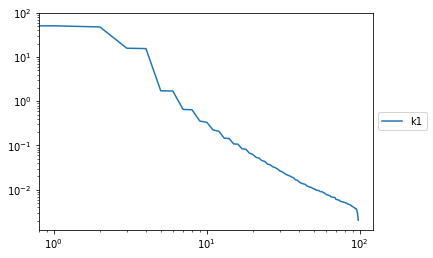

In [11]:
# step 1c: K1
K1 = sigma_1 + K_0 * sigma_1_prime

check(K1)

plot_eigendecay(K1, 'k1')

In [12]:
# 2a: B2
v3 = np.vstack((sigma_1, sigma_1))
v4 = np.vstack((sigma_1, sigma_1))

B_2 = np.hstack((v3, v4))

B_2.shape

(200, 200)

In [13]:
# 2b: sigma_2

# activation function setup
activation_h1 = 'relu_k'
k = 1

activation_map = {
    'relu_k': [relu_k, d_relu_k],
    'sin': [sin, cos],
    'cos': [cos, d_cos]
}

activation_func, d_activation = activation_map[activation_h1]

num_samples = 1000

mean_2 = np.zeros(2 * num_inputs)
cov_2 = B_2
# generate 1000 pairs of (u, v), apply activation array-wise then take average
sample_1, sample_2 = np.random.multivariate_normal(mean_2, cov_2, (2, num_samples)) # each (num_samples, 2*num_inputs)
u1, v1 = sample_1[:, :num_inputs], sample_1[:, num_inputs:] # (num_samples, num_inputs)
u2, v2 = sample_2[:, :num_inputs], sample_2[:, num_inputs:] # (1000, 100)

expectation_1 = np.dot(activation_func(u1, k).T, activation_func(v1, k)) / num_samples
expectation_2 = np.dot(d_activation(u2, k).T, d_activation(v2, k)) / num_samples

sigma_2 = 2 * expectation_1
sigma_2_prime = 2 * expectation_2

In [ ]:
# step 2c: K2
K2 = sigma_2 + K_1 * sigma_2_prime

check(K2)

plot_eigendecay(K2, 'k2')

In [ ]:
# execute
"""
experiment:
1. first hidden layer: smooth (sin/cos), second: non-smooth (ReLU^k)
2. reverse the order of activation
"""    
def calc_NTK(activation_h1='relu_k', activation_h2='sin', k=1):   

    # init input
    x = init_inputs() # (2, 100)
    num_inputs = x.shape[1]
    
    # first calculate B_k and then we sample
    B1 = np.zeros((2*num_inputs, 2*num_inputs))
    B2 = np.zeros((2*num_inputs, 2*num_inputs))
    

    # initialize kernel 
    kernel = np.zeros((num_inputs, num_inputs))
    
    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = K_2(x[:, i], x[:, j], activation_h1, activation_h2, k)
    
    check(kernel)
    
    return kernel

In [ ]:
# TO FIX: you cannot sample from gaussian entry-wise
# look at your previous work!!!
# solution: maybe get the B_1 and B_2 first then sample once for all entries?

# TODO:
# 1. get whole kernel working, plot eigen decay
# 2. clean up your code make it modular and compact
# 4. vectorize if you can
# 5. when you write up doc, refer to your commit history

In [ ]:
"""
Analytic Solution
page 4 equation (6)-(7)
"""
def kappa_0(u):
    pi = np.pi
    k_0 = (1/pi) * (pi - np.arccos(u))
    return k_0

def kappa_1(u):
    pi = np.pi
    k_1 = (1/pi) * (u * (pi - np.arccos(u)) + np.sqrt(1 - u**2))
    return k_1

def K_0_analytical(x, y):
    return np.dot(x.T, y)

def sigma_0_analytical(x, y):
    return np.dot(x.T, y)

def sigma_1_and_prime_analytical(x, y):
    sig_0_xx = sigma_0_analytical(x, x)
    sig_0_yy = sigma_0_analytical(y, y)
    sig_0_xy = sigma_0_analytical(x, y)
    sqrt_term = np.sqrt(sig_0_xx * sig_0_yy)
    
    u = sig_0_xy / sqrt_term
    k_1 = kappa_1(u)
    sigma_1 = sqrt_term * k_1
    sigma_1_prime = kappa_0(u)
    
    return sigma_1, sigma_1_prime
    
def sigma_2_prime_analytical(x, y):
    sig_1_xx, _ = sigma_1_and_prime_analytical(x, y)
    sig_1_xy, _ = sigma_1_and_prime_analytical(x, y)
    sig_1_yy, _ = sigma_1_and_prime_analytical(y, y)
    sqrt_term = np.sqrt(sig_1_xx * sig_1_yy)
    
    u = sig_1_xy / sqrt_term
    k_1 = kappa_1(u)
    sigma_2 = sqrt_term * k_1
    sigma_2_prime = kappa_0(u)
    
    return sigma_2, sigma_2_prime

def K_1_analytical(x, y):
    sigma_1, sigma_1_prime = sigma_1_and_prime_analytical(x, y)
    K_0 = K_0_analytical(x, y)
    K_1 = sigma_1 + 2 * K_0 * sigma_1_prime
    return K_1

def K_2_analytical(x, y):
    sigma_2, sigma_2_prime = sigma_2_prime_analytical(x, y)
    K_1 = K_1_analytical(x, y)
    K_2 = sigma_2 + 2 * K_1 * sigma_2_prime
    return K_2

In [ ]:
# execute
"""
experiment:
1. first hidden layer: smooth (sin/cos), second: non-smooth (ReLU^k)
2. reverse the order of activation
"""    
def calc_NTK_analytical():   

    # init input
    x = init_inputs() # (2, 100)
    num_inputs = x.shape[1]

    # initialize kernel and sample weights
    kernel = np.zeros((num_inputs, num_inputs))
    
    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = K_2_analytical(x[:, i], x[:, j])
    
    check(kernel)
    
    return kernel

In [ ]:
kernel_analytical = calc_NTK_analytical()

plot_eigendecay(kernel_analytical, 'analytical')
plot_eigendecay(kernel_3, 'numerical relu+relu')